[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yueliyl/comp551-notebooks/blob/master/LogisticRegression.ipynb)


# Logistic Regression
In logistic regression we perform binary classification of by learnig a function of the form $f_w(x) = \sigma(x^\top w)$. Here $x,w \in \mathbb{R}^D$, where $D$ is the number of features as before. $\sigma(z) = \frac{1}{1+e^{-z}}$ is the logistic function.  Let's plot this function below

Given that the true label $y=1$, the SSE is 0 if and only if $\hat{y}^{(n)} = 1$. SEE increases even if $\hat{y}^{(n)}$ is highly positive (indicating that the model is confident about the true positive label). In contrast, another error function called \textbf{cross-entropy} decreases $\hat{y}^{(n)}$ becomes more positive and converges to 0 as $\hat{y}^{(n)} \rightarrow \infty$. 

In [241]:
import numpy as np
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

np.random.seed(1234)

# Comparison of cost functions

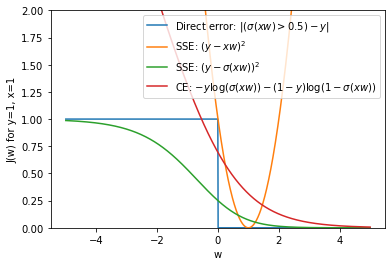

In [242]:
xw = np.linspace(-5,5,1000) # assume x = 1 and changing w
y_true = np.ones(len(xw))

sse_xw = (xw-y_true)**2

p = 1/(1+np.exp(-xw))
ce = -y_true * np.log(p) # cross-entropy

sse_yh = (p-y_true)**2

misc = (p > 0.5) != y_true # absolute error

plt.clf()

plt.plot(xw, misc, "-", label="Direct error: $|(\sigma(xw) > 0.5) - y|$")
plt.plot(xw, sse_xw, "-", label="SSE: $(y-xw)^2$")
plt.plot(xw, sse_yh, "-", label="SSE: $(y-\sigma(xw))^2$")
plt.plot(xw, ce, "-", label="CE: $-y\log(\sigma(xw)) - (1-y)\log(1-\sigma(xw))$")
plt.xlabel("w")
plt.ylabel("J(w) for y=1, x=1")
plt.legend()
plt.ylim((0,2))
# plt.show()
plt.savefig('loss_functions.png', bbox_inches="tight", dpi=300)

Logistic function transforms the real-value $\mathbf{a}=\mathbf{X}\mathbf{w} \in \mathbb{R}$ into $\hat{y} \in [0,1]$, which can be interpreted as the \emph{probability} being class 1.
	\begin{equation}
		\hat{y} = \sigma(a) = \frac{1}{1+\exp(-a)}
	\end{equation}

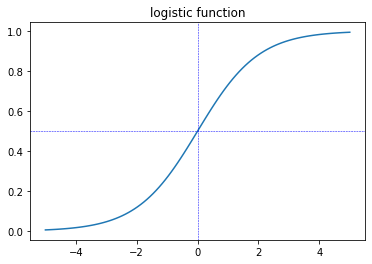

In [243]:
logistic = lambda z: 1./ (1 + np.exp(-z))       #logistic function
z = np.linspace(-5,5,100)
plt.plot(z, logistic(z))
plt.axhline(y = 0.5, color = 'b', linestyle = 'dashed', lw=0.5)
plt.axvline(x = 0, color = 'b', linestyle = 'dashed', lw=0.5)
plt.title('logistic function')
plt.savefig('logistic_function.png', bbox_inches="tight", dpi=300)

Given that $\hat{y} = 1/(1+\exp(-\mathbf{x}\mathbf{w}))$, we consider three candidate loss functions. Direct loss is not differentiable so we cannot use gradient descent:
\begin{equation*}
	\mathcal{L}(\hat{y}, y) = |\mathbb{I}(\hat{y} > 0.5) - y|
\end{equation*}

The SSE loss is non-convex to optimize:
\begin{equation*}
	\mathcal{L}(\hat{y}, y) = (\hat{y} - y)^2
\end{equation*}
\textbf{cross-entropy} (CE) is convex in $\mathbf{w}$ and has probabilistic interpretation (i.e., See Lecture 6 slides  on Bernoulli likelihood):
\begin{equation*}
	CE(\hat{y}, y) = -y\log(\hat{y}) - (1-y)\log(1-\hat{y})
\end{equation*}

## Cost function
To fit our model $f_w$ to the data $\mathcal{D} = \{x^{(1)}, \ldots, x^{(N)}\}$, we maximize the **logarithm of the conditional likelihood**:

$$
\ell(w; \mathcal{D}) = \sum_n \log \mathrm{Bernoulli}(y^{(n)} | \sigma({x^{(n)}}^\top w)) = \sum_n y^{(n)} \log \sigma({x^{(n)}}^\top w)) + (1-y^{(n)}) \log (1-\sigma({x^{(n)}}^\top w)))
$$

by substituting the definition of logistic function in the equation above, and minimizing the **negative** of the log-likelihood, which is called the **cost function**,
we get

$$
J(w) = \sum_n y^{(n)} \log(1+e^{-x w^\top}) + (1-y^{(n)}) \log(1+e^{x w^\top})
$$

In practice we use mean rather than sum over data points.

In [244]:
def cost_fn(x, y, w):
    N, D = x.shape                                                       
    z = np.dot(x, w)
    J = np.mean(y * np.log1p(np.exp(-z)) + (1-y) * np.log1p(np.exp(z)))  #log1p calculates log(1+x) to remove floating point inaccuracies 
    return J

\begin{align*}
	J(w) 
	&= -\sum_n y^{(n)}\log(\frac{1}{1+\exp(-a)}) - (1-y^{(n)})\log(1-\frac{1}{1+\exp(-a)})\\
	&= \sum_n y^{(n)}\log(1+\exp(-a)) - (1-y^{(n)})\log(\frac{\exp(-a)}{1+\exp(-a)})\\
	&= \sum_n y^{(n)}\log(1+\exp(-a)) - (1-y^{(n)})\log(\frac{1}{\exp(a)+1})\\	
	&= \sum_n y^{(n)}\log(1+\exp(-a)) + (1-y^{(n)})\log(1+\exp(a))
\end{align*}

Try this:

In [245]:
print(np.log(1+1e-100)) # 0
print(np.log1p(1e-100)) # 1e-100

0.0
1e-100


## Minimizing the cost using gradient descent
To minimize the cost we use gradient descent: start from some initial assignment to the parameters $w$, and at each iteration take a small step in the opposite direction of the *gradient*. The gradient of the cost function above is given by:

$$
\frac{\partial}{\partial w_d} J(w) =\sum_n - y^{(n)} x^{(n)}_d \frac{e^{-w^\top x^{(n)}}}{1 + e^{-w^\top x^{(n)}}} +x^{(n)}_d (1- y^{(n)}) \frac{e^{w^\top x^{(n)}}}{1 + e^{w^\top x^{(n)}}} = \sum_n - x^{(n)}_d y^{(n)} (1-\hat{y}^{(n)})+ x^{(n)}_d (1- y^{(n)}) \hat{y}^{(n)} = x^{(n)}_d (\hat{y}^{(n)} - y^{(n)}) 
$$
Since in practice we divide the cost by $N$, we have to the same for the gradient; see the implementation below.

# Gradient of cross entropy loss for logistic regression

In [246]:
def gradient(self, x, y):
    N,D = x.shape
    yh = logistic(np.dot(x, self.w))    # predictions  size N
    grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
    return grad                         # size D

# Verifying gradient calculation 1: small perturbation
Gradient calculation by hand as shown above can be error-prone. We can verify the gradient as follow:

1. $\epsilon \sim Uniform([0,1])$
2. $w^{(+)}_d = w_d + \epsilon$
3. $w^{(-)}_d = w_d - \epsilon$
4. $\nabla w_d = \frac{J(w^{(+)}_d) - J(w^{(-)}_d)}{2 \epsilon}$ (numerically estimated gradient)
5. $\frac{(\frac{\partial J(w)}{\partial w}  - \nabla w_d)^2}{(\frac{\partial J(w)}{\partial w}  + \nabla w_d)^2}$ must be small (e.g., $10^{-8}$) otherwise your gradient calculation and/or your loss function is incorrect

See an implementation of the above below.

In [247]:
N=50
x = np.linspace(-5,5, N)
y = (x > 0.5).astype(int)

# small perturbation
w = np.random.randn(1)
w0 = w
epsilon = np.random.randn(1)[0] * 1e-5
w1 = w0 + epsilon
w2 = w0 - epsilon
a1 = w1*x
a2 = w2*x
ce1 = np.sum(y * np.log1p(np.exp(-a1)) + (1-y) * np.log1p(np.exp(a1)))
ce2 = np.sum(y * np.log1p(np.exp(-a2)) + (1-y) * np.log1p(np.exp(a2)))
dw_num = (ce1 - ce2)/(2*epsilon) # approximated gradient

yh = 1/(1+np.exp(-x * w))
dw_cal = np.sum((yh - y) * x) # hand calculated gradient

print(dw_cal)
print(dw_num)
print((dw_cal - dw_num)**2/(dw_cal + dw_num)**2)

-22.812099331382
-22.812099334497717
4.6636413252871234e-21


# Verifying gradient calculation 2: monitor loss at each iteration

We can monitor error decreases at each iteration

<Figure size 432x288 with 0 Axes>

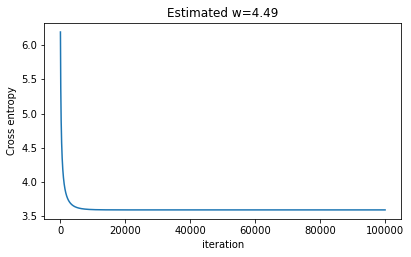

In [248]:
# monitor loss
lr = 0.001
niter = 100000
ce_all = np.zeros(niter)
w = np.random.randn(1)
w0 = w
for i in range(niter):
    a = w * x
    ce_all[i] = np.sum(y * np.log1p(np.exp(-a)) + (1-y) * np.log1p(np.exp(a))) # cross-entropy
    y_hat = 1 / (1 + np.exp(-a))
    dw = np.sum((y_hat - y) * x)
    w = w - lr * dw

plt.clf()
plt.figure(figsize=((16/9)*3.6,3.6))
plt.plot(ce_all)
plt.ylabel("Cross entropy")
plt.xlabel("iteration")
# plt.title(f"True w={w_true}; Estimated w={round(w.astype(float)[0],2)}")
plt.title(f"Estimated w={round(w.astype(float)[0],2)}")
# plt.show()
plt.savefig('ce_iteration.png', bbox_inches="tight", dpi=300)

## Logistic regression class
Now we are ready to implement the logistic regression class with the usual `fit` and `predict` methods. Here, the `fit` method implements gradient descent.

In [249]:
class LogisticRegression:
    
    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients 
        self.max_iters = max_iters                    #maximum number of iteration of gradient descent
        self.verbose = verbose

    def gradient(self, x, y):
        N,D = x.shape
        yh = logistic(np.dot(x, self.w))    # predictions  size N
        grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
        return grad
        
    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf 
        t = 0
        # the code snippet below is for gradient descent
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            g = self.gradient(x, y)
            self.w = self.w - self.learning_rate * g 
            t += 1
        
        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))            #predict output
        return yh

# LogisticRegression.gradient = gradient             #initialize the gradient method of the LogisticRegression class with gradient function

## Toy experiment

fit this linear model to toy data with $x \in \Re^1$ + a bias parameter

terminated after 10641 iterations, with norm of the gradient equal to 9.997324612981251e-05
the weight found: [4.46302079]


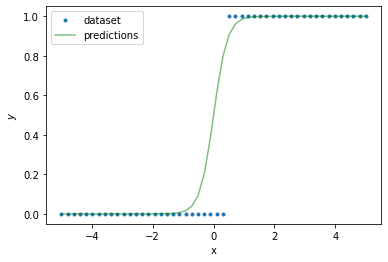

In [250]:
N = 50
x = np.linspace(-5,5, N)
y = (x > 0.5).astype(int)                                  #generate synthetic data
model = LogisticRegression(verbose=True, add_bias=False)
yh = model.fit(x,y).predict(x)
plt.plot(x, y, '.', label='dataset')
plt.plot(x, yh, 'g', alpha=.5, label='predictions')
plt.xlabel('x')
plt.ylabel(r'$y$')
plt.legend()
# plt.show()
plt.savefig('toy_prediction.png', bbox_inches="tight", dpi=300)

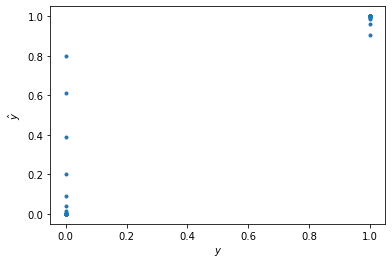

In [251]:
plt.plot(y, yh, '.')
plt.xlabel(r'$y$')
plt.ylabel(r'$\hat{y}$')
plt.savefig('toy_prediction_yh_vs_y.png', bbox_inches="tight", dpi=300)

We see that the model successfully fits the training data. If we run the optimization for long enough the weights will grow large (in absolute value) so as to make the predicted probabilities for the data-points close to the decidion boundary (x=2) close to zero and one.


## Weight Space
Similar to what we did for linear regression, we plot *cost* as a function for logistic regrression as a function of model parameters (weights), and show the correspondence between the different weights having different costs and their fit. 
The `plot_contour` is the same helper function we used for plotting the cost function for linear regression.

In [252]:
import itertools
def plot_contour(f, x1bound, x2bound, resolution, ax):
    x1range = np.linspace(x1bound[0], x1bound[1], resolution)
    x2range = np.linspace(x2bound[0], x2bound[1], resolution)
    xg, yg = np.meshgrid(x1range, x2range)
    zg = np.zeros_like(xg)
    for i,j in itertools.product(range(resolution), range(resolution)):
        zg[i,j] = f([xg[i,j], yg[i,j]])
    ax.contour(xg, yg, zg, 100)
    return ax

Now let's define the cost function for linear regression example above, and visualize the cost and the fit of various models (parameters).

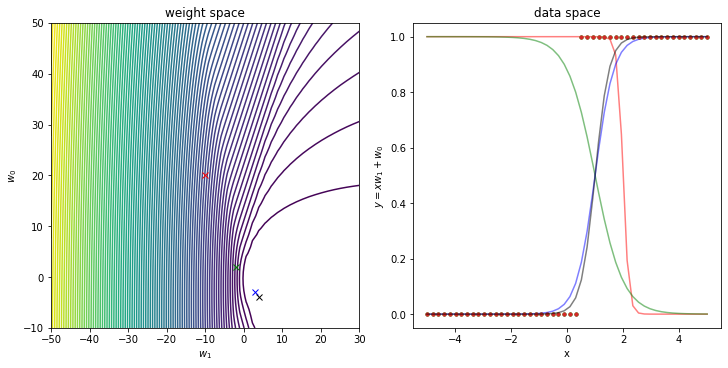

In [253]:
x_plus_bias = np.column_stack([x,np.ones(x.shape[0])])
cost_w = lambda param: cost_fn(x_plus_bias, y, param)           #define the cost just as a function of parameters
model_list = [(-10, 20), (-2, 2), (3,-3), (4,-4)]
fig, axes = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(10, 5))
plot_contour(cost_w, [-50,30], [-10,50],  50, axes[0])
colors = ['r','g', 'b', 'k']
for i, w in enumerate(model_list):
    axes[0].plot(w[0], w[1], 'x'+colors[i])
    axes[1].plot(x, y, '.')
    axes[1].plot(x, logistic(w[1] + np.dot(w[0], x)), '-'+colors[i], alpha=.5)
axes[0].set_xlabel(r'$w_1$')
axes[0].set_ylabel(r'$w_0$')
axes[0].set_title('weight space')
axes[1].set_xlabel('x')
axes[1].set_ylabel(r'$y=xw_1 + w_0$')
axes[1].set_title('data space')
# plt.show()
plt.savefig('contour.png', bbox_inches="tight", dpi=300)

# Titanic dataset application

In [254]:
from sklearn import model_selection
import pandas as pd
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('titanic.csv')

X = data.drop(["survived"], axis=1).values
y = data["survived"].values
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size = 0.2, random_state=1, shuffle=True)

X_train = StandardScaler().fit(X_train).transform(X_train)
X_test = StandardScaler().fit(X_test).transform(X_test)

# our implementation is slow you may try sklearn version
logitreg = LogisticRegression(max_iters=1e3)
fit = logitreg.fit(X_train, y_train)
effect_size = pd.DataFrame(fit.w[:(len(fit.w)-1)]).transpose() # linear coefficents
# effect_size.shape
effect_size.columns = data.drop(["survived"], axis=1).columns
print(effect_size.to_string(index=False))

   pclass      sex       age     sibsp    parch     fare
-0.902971 1.149995 -0.550537 -0.328619 0.121769 0.055486


<Figure size 432x288 with 0 Axes>

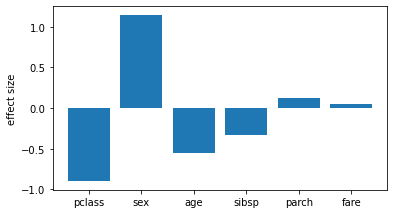

In [255]:
import matplotlib.pyplot as plt
plt.clf()
plt.figure(figsize=(6, 6/(16/9)))
plt.bar(list(effect_size.columns.values), effect_size.stack().tolist())
plt.ylabel("effect size")
# plt.show()
plt.savefig("effect_size.png", bbox_inches='tight', dpi=300)

## Classification accuracy

In [256]:
y_train_pred = fit.predict(X_train)
y_test_pred = fit.predict(X_test)

# threshold probabilities
y_train_pred = (y_train_pred > 0.5).astype(int)
y_test_pred = (y_test_pred > 0.5).astype(int)

# accuracy = correctly classified / total classified
acc_train = sum(y_train_pred==y_train)/len(y_train)
acc_test = sum(y_test_pred==y_test)/len(y_test)
print(f"train accuracy: {acc_train:.3f}; test accuracy: {acc_test:.3f}")

train accuracy: 0.779; test accuracy: 0.837


## Method comparison using ROC curve

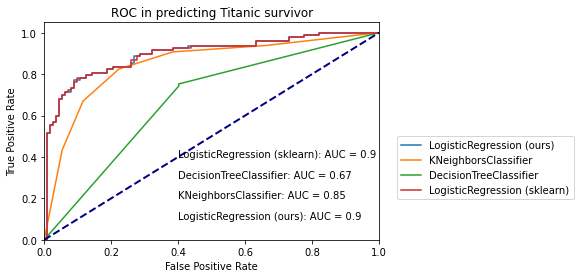

In [257]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression as sk_LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

models = [KNeighborsClassifier(),
          DecisionTreeClassifier(),
          sk_LogisticRegression()]

perf = {}

# our implementation is slow you may try sklearn version
logitreg = LogisticRegression(max_iters=1e3)
fit = logitreg.fit(X_train, y_train)
y_test_prob = fit.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
auroc = roc_auc_score(y_test, y_test_prob)
perf["LogisticRegression (ours)"] = {'fpr':fpr, 'tpr':tpr, 'auroc':auroc}

for model in models:
    fit = model.fit(X_train, y_train)
    y_test_prob = fit.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    auroc = roc_auc_score(y_test, y_test_prob)
    if type(model).__name__ == "LogisticRegression":
        perf["LogisticRegression (sklearn)"] = {'fpr':fpr,'tpr':tpr,'auroc':auroc}
    else:
        perf[type(model).__name__] = {'fpr':fpr,'tpr':tpr,'auroc':auroc}


plt.clf()
i = 0
for model_name, model_perf in perf.items():
    plt.plot(model_perf['fpr'], model_perf['tpr'],label=model_name)
    plt.text(0.4, i+0.1, model_name + ': AUC = '+ str(round(model_perf['auroc'],2)))
    i += 0.1

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC in predicting Titanic survivor')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="upper left")
# plt.show()
plt.savefig("roc_curve.png", bbox_inches='tight', dpi=300)
# plt.close()
